In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.0 MB/s 


In [66]:
from torch.utils.data import Dataset
import torch
import pickle
import mne
import numpy as np
import time

class Sleepedf_dataset(Dataset):
    def __init__(self, files):
        self.files = files
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
        

        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 1, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 1, keepdims=True) # shape = c,t
        c,t = data.shape
        
        return data/data_max*np.ones((c,t)) - (data_max - data_min)*np.ones((c,t))/(self.max_value - self.min_value)

    def one_hot_encoding(self,y):
        if y == '1':
          y = np.array([0,1,0,0,0,0])
        elif y == '2':
          y = np.array([0,0,1,0,0,0])   
        elif y == '3':
          y = np.array([0,0,0,1,0,0])
        elif y == '4':
          y = np.array([0,0,0,0,1,0])
        elif y == 'R':
          y = np.array([0,0,0,0,0,1])
        else:
          y = np.array([1,0,0,0,0,0])      
        return y  


    def __getitem__(self, index):          
        sample = np.load(self.files[index])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.preprocessing(sample['x'])
        return { 'x' : torch.tensor(sample), 
                 'y' : torch.tensor(y)
                   }
          
    def __len__(self):
        return len(self.files)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import glob

SleepEDF_file_list = glob.glob('/content/drive/MyDrive/sleep_edfx/Preprocessed_EEG/SC/**')
print(len(SleepEDF_file_list[0]))
SleepEDF_list = []
for i in range(2):
    SleepEDF_list.extend(glob.glob(SleepEDF_file_list[i]+'/**'))
print(len(SleepEDF_list))

62
5480


In [50]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(SleepEDF_list, test_size=0.2)#, shuffle=True, random_state=34), #stratify=target
train, val = train_test_split(train, test_size= 0.25)#, shu

In [67]:
train_dataset = Sleepedf_dataset(train)
val_dataset = Sleepedf_dataset(val)
test_dataset = Sleepedf_dataset(test)

In [7]:
!pip install separableconv-torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import numpy as np
import torch
import torch.nn as nn
from mne.filter import filter_data, notch_filter
import matplotlib.pyplot as plt


class Encoder(nn.Module):
    def __init__(self, fs, encode_info):
        super(Encoder, self).__init__()
        #spectral layer means spectral convolution
        #self.bac_layer is consist of several SeparableConv2d, which plays the role of temporal separable convolution
        #convolution layer are initiated by xavier_uniform initization
        #Input are Normalized by self.bn(=torch.nn.BatchNorm2d)
        #[batch, electrode, length] -> [batch, electrode, Feature]
        self.fs = fs
        self.elu = nn.ELU()
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.bn = nn.BatchNorm1d(1)
        self.activation = nn.LeakyReLU()

        self.spectral_layer = nn.Conv1d(1, 10, int(self.fs/2), padding="same")

        # self.bac_layer = nn.Sequential()
        # for i, arg in enumerate(encode_info):
        #     input_dim, output_dim, kernel_size = arg
        #     self.bac_layer.add_module("temporal_conv_"+str(i),
        #                           nn.Conv1d(input_dim, output_dim, kernel_size, padding = 'same'))
        #     self.bac_layer.add_module("ELU",nn.ELU()) 
        
        self.conv1t = nn.Conv1d(10,16, 30, padding ='same')
        self.conv2t = nn.Conv1d(16,32, 15, padding ='same')
        self.conv3t = nn.Conv1d(32,64, 5, padding ='same')
        
        torch.nn.init.xavier_uniform_(self.spectral_layer.weight)
        #self.bac_layer.apply(weight_init_xavier_uniform)

    def forward(self, x):
        x = self.activation(self.spectral_layer(x))
        x = self.activation(self.conv1t(x))
        x = self.activation(self.conv2t(x))
        x = self.activation(self.conv3t(x))

        return x

#Linear layer for SSL classification
class Head_NN(nn.Module):
    def __init__(self):
        super(Head_NN, self).__init__()        
        # self.layer = nn.Sequential(
        #     nn.Dropout(0.5),
        #     nn.Linear(64*length, 5)
        # )
        
        self.layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 5)
        )
        
        self.softmax = torch.nn.Softmax()
        # self.layer.apply(weight_init_xavier_uniform)
        self.bn = nn.BatchNorm1d(64)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = torch.mean(x, axis = 2) # Global average pooling into temporal dimension
        # x = self.flatten(x)
        x = self.layer(x)
        x = self.softmax(x)
        return x

class StoppedBandPathway(nn.Module):
    def __init__(self, fs, Unsupervise, encode_info, bands):
        super(StoppedBandPathway, self).__init__()
        self.encoder = Encoder(fs, encode_info)
        self.pretrain = Head_NN()
        self.Unsupervise = Unsupervise


    def forward(self, x):
        x = self.encoder(x)
        x = self.pretrain(x)
        return x

    def getRep(self, x):
        x = self.encoder(x)
        return x


In [36]:
class feature_extractor3(nn.Module):
    def __init__(self):
        super(feature_extractor3,self).__init__()
        
        self.channels = 1 # we use only single channel 
        
        # Activation functions
        self.activation = nn.LeakyReLU()
        # self.bn = nn.BatchNorm1d(1)

        # self.conv2t = nns.SeparableConv1d(16,32,10,padding ='same') (in_channels, out_channels, kernel size,,,) 

        self.softmax = nn.Softmax()
        self.conv1t = nn.Conv1d(1,10, 30, padding ='same') #in_channels, out_channels, kernel_size, 
        self.conv1s = nn.Conv1d(10,10,self.channels)
        self.conv2t = nn.Conv1d(10,20,15,padding ='same') 
        self.conv2s = nn.Conv1d(20,20,self.channels)
        self.conv3t = nn.Conv1d(20,34,5,padding ='same')
        self.conv3s = nn.Conv1d(34,34,self.channels)
        
                  
        # Flatteninig
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Decision making
        self.Linear = nn.Linear(256000 ,4) # 

      
    def embedding(self, x):
        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))
        
        # multi-scale feature representation by exploiting intermediate features
        feature = torch.cat([f1, f2, f3],dim = 1 )
        
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.Linear(feature))
        return y_hat    

    def forward(self, x):
        feature = self.embedding(x)
        y_hat = self.classifier(feature)
        return y_hat

In [37]:
import numpy as np
import torch
import torch.nn as nn
# import separableconv.nn as snn

class FeatureEncoder(nn.Module):
    def __init__(self,x1,x2):
        super(FeatureEncoder, self).__init__()
        self.sepctral_rept = x1
        self.temporal_rept = x2
        self.spatial_conv = nn.Conv2d(64,64, (2,1))
        #self.GVP = torch.var(dim=-1) 

    def fGAP(self, x):
        #  x.shape = batch*channel, feature, time -->
        x = torch.tensor(x)
        x = torch.mean(x, 2) # channel
        x = torch.mean(x, 2) # time
        return x

    def fGVP(self, x):
         #  x.shape = batch,  channel, feature, time -->
        x = torch.tensor(x)
        x = torch.var(x, 2) # channel
        x = torch.var(x, 2) # time
        return x    
    

    def forward(self,b,c,f,t):
        f_1 = self.sepctral_rept
        f_2 = self.temporal_rept
        f_1 = torch.reshape(f_1,(b,f,c,t)) 
        f_2 = torch.reshape(f_2,(b,f,c,t)) 
        # print(f_1.shape,f_2.shape)
        f_GAP = torch.cat(( self.fGAP(f_1),self.fGAP(f_2) ), axis=1)
        f_GVP = torch.cat((self.fGVP(f_1),self.fGVP(f_2)), axis=1)
        # print(f_GAP.shape,f_GVP.shape)


        return  f_GAP, f_GVP


class StatisticianModule(nn.Module):
    def __init__(self, dense, classes):
        super(StatisticianModule, self).__init__()
        self.classes = classes

        self.softmax = torch.nn.Softmax(dim=1)
        self.c_dense = nn.Linear(dense, 64*2*2) # 64*2*2

        self.gap_pwconv = nn.Conv1d(128, dense, 1) 
        self.gvp_pwconv = nn.Conv1d(128, dense, 1)

        self.fullconnect = nn.Linear(dense, self.classes)


    def forward(self, f_GAP, f_GVP):
        #[batch, gap+gvp] -> [batch,dense]
      
        c = self.softmax(self.c_dense(torch.cat((f_GAP, f_GVP),axis=1)))
        # print('c:',c.shape)
        #[batch, gap, 1] -> [batch, 1, dense] -> [batch, dense]
        f_GAP_d = self.gap_pwconv(f_GAP.unsqueeze(dim=-1)).squeeze()
        f_GVP_d = self.gvp_pwconv(f_GVP.unsqueeze(dim=-1)).squeeze()
        
        f_GAP_dd = torch.sum(c*f_GAP_d,dim=1)
        f_GVP_dd = torch.sum(c*f_GVP_d,dim=1)
        # print('f_GAP_dd: ',f_GAP_dd.shape)
        ALN = torch.div(torch.sub(f_GAP_d.T,f_GAP_dd),f_GAP_dd).T
        # print('ALN', ALN.shape)

        y_hat = self.fullconnect(ALN)
        # print('y_hat: ',y_hat.shape)
        return y_hat

In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# import separableconv.nn as nn

# class FeatureEncoder(nn.Module):
#     def __init__(self,x1,x2):
#         super(FeatureEncoder, self).__init__()
#         self.sepctral_rept = x1
#         self.temporal_rept = x2
#         self.conv = nn.Conv2d(1,16, (1,2), padding ='same')
#         #self.GVP = torch.var(dim=-1)

#     def Temporal_GAP(self, x):
#          #  x.shape = batch*channel, feature, time -->
#         x = torch.tensor(x)
#         x = torch.mean(x, 1) # channel
#         x = torch.mean(x, 2) # time
#         return x

#     def Temporal_GVP(self, x):
#          #  x.shape = batch,  channel, feature, time -->
#         x = torch.tensor(x)
#         x = torch.var(x, 1) # channel
#         x = torch.var(x, 2) # time
#         return x    

#     def forward(self,b,c,f,t):
#         f_1 = self.sepctral_rept
#         f_2 = self.temporal_rept
#         f_1 = torch.reshape(f_1,(b,c,f,t))
#         f_2 = torch.reshape(f_2,(b,c,f,t))
#         f_1 = self.conv(f_1)
#         f_2 = self.conv(f_2)

        
#         f_GAP = torch.cat(( self.Temporal_GAP(f_1), self.Temporal_GAP(f_2)), axis=1)
#         f_GVP = torch.cat((self.Temporal_GVP(f_1), self.Temporal_GVP(f_2)), axis=1)
      
#         # f_GAP = torch.cat((self.GAP(f_1).squeeze(), self.GAP(f_2).squeeze(), self.Temporal_GAP(f_3).squeeze()), axis=1)
#         # f_GVP = torch.cat((torch.var(f_1, dim=-1), torch.var(f_2, dim=-1), torch.var(f_3, dim=-1)), axis=1)

#         return  f_GAP, f_GVP


# class StatisticianModule(nn.Module):
#     def __init__(self, dense, classes):
#         super(StatisticianModule, self).__init__()
#         self.classes = classes

#         self.softmax = torch.nn.Softmax(dim=1)
#         self.c_dense = nn.Linear(dense, 64*2*2)

#         self.gap_pwconv = nn.Conv1d(64*2, dense, 1)
#         self.gvp_pwconv = nn.Conv1d(64*2, dense, 1)

#         self.fullconnect = nn.Linear(dense, self.classes)


#     def forward(self, f_GAP, f_GVP):
#         #[batch, gap+gvp] -> [batch,dense]
      
#         c = self.softmax(self.c_dense(torch.cat((f_GAP, f_GVP),axis=1)))
#         # print('c:',c.shape)
#         #[batch, gap, 1] -> [batch, 1, dense] -> [batch, dense]
#         f_GAP_d = self.gap_pwconv(f_GAP.unsqueeze(dim=-1)).squeeze()
#         f_GVP_d = self.gvp_pwconv(f_GVP.unsqueeze(dim=-1)).squeeze()
        
#         f_GAP_dd = torch.sum(c*f_GAP_d,dim=1)
#         f_GVP_dd = torch.sum(c*f_GVP_d,dim=1)
#         # print('f_GAP_dd: ',f_GAP_dd.shape)
#         ALN = torch.div(torch.sub(f_GAP_d.T,f_GAP_dd),f_GAP_dd).T
#         # print('ALN', ALN.shape)

#         y_hat = self.fullconnect(ALN)
#         # print('y_hat: ',y_hat.shape)
#         return y_hat

load pretrain model

In [113]:
FE1 = torch.load('/content/Spectral__1s_ep19_.pt')
FE2 = torch.load('/content/Temporal_1s_ep10_.pt')
FE1.eval()
FE2.eval()


feature_extractor3(
  (activation): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=None)
  (conv1t): Conv1d(1, 10, kernel_size=(30,), stride=(1,), padding=same)
  (conv1s): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
  (conv2t): Conv1d(10, 20, kernel_size=(15,), stride=(1,), padding=same)
  (conv2s): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (conv3t): Conv1d(20, 34, kernel_size=(5,), stride=(1,), padding=same)
  (conv3s): Conv1d(34, 34, kernel_size=(1,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (Linear): Linear(in_features=12800, out_features=4, bias=True)
)

In [114]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"

print(device)


cuda:0


In [115]:
epochs = 30
learning_rate = 0.0001
batch_size = 128
model = StatisticianModule(256,6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [116]:
from torch.utils.data import DataLoader


trainLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)


In [ ]:
# for batch_idx, batch in enumerate(SleepEDF_list):
#     a = np.load(batch)
#     if a['y'] != 'W' and a['y'] !='R' and a['y'] !='1' and a['y'] !='2' and a['y'] !='3' and a['y'] !='4':
#       print(a['y'])


In [118]:
loss_tr = []
loss_val = []
acc_tr = []
acc_val = []
for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        f_GAP, f_GVP =  FeatureEncoder(x1,x2).forward(b,c,f,t)
        pred  = model.forward(f_GAP, f_GVP)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
       
        loss = CrossEL(pred, label)
        loss.backward(retain_graph=True)
        optimizer.step() 

        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0] #acc/(batch*channels*4(augmented))
        loss_ep += loss.item()
        # print('acc:', acc)
        acc_ep += acc

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))        

    loss_ep_val = 0
    acc_ep_val = 0
    
    for batch_idx, batch in enumerate(valLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        f_GAP, f_GVP =  FeatureEncoder(x1,x2).forward(b,c,f,t)

        pred  = model.forward(f_GAP, f_GVP)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
        loss = CrossEL(pred, label)
        
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0]

        loss_ep_val += loss.item()
        acc_ep_val += acc

    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])
    torch.save(model,'SleepEDF_noConv_1s_ep' + str(epoch)+'_.pt')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch :  0   train loss :  2.178537589010347 train acc :  0.5081676136363636     val loss :  1.5732524258324199 val acc :  0.6928047839506173
epoch :  1   train loss :  1.5638204981121702 train acc :  0.6811079545454545     val loss :  1.4205178104424996 val acc :  0.6929012345679012
epoch :  2   train loss :  1.691965483404411 train acc :  0.6800972465034966     val loss :  1.4391910261817662 val acc :  0.6984953703703703
epoch :  3   train loss :  1.4655803383807866 train acc :  0.677857298951049     val loss :  1.4367360449722482 val acc :  0.6609760802469136
epoch :  4   train loss :  1.598624657529316 train acc :  0.6489565122377622     val loss :  2.6822019293315043 val acc :  0.7044753086419753
epoch :  5   train loss :  1.616655497982387 train acc :  0.6616313374125874     val loss :  1.5863547547331973 val acc :  0.6157407407407408
epoch :  6   train loss :  1.506794394544998 train acc :  0.656058784965035     val loss :  1.0966234782516144 val acc :  0.7228009259259259
epoch 

In [119]:
import pandas as pd
col = ['loss_tr','loss_val','acc_tr','acc_val']
data = np.array([loss_tr,
                 loss_val,
                 acc_tr,
                 acc_val])
print(data.shape)
data = np.transpose(data)
df = pd.DataFrame(data = data, columns= col)
df.to_excel('SleepEDF_1s.xlsx', index = False)


(4, 30)


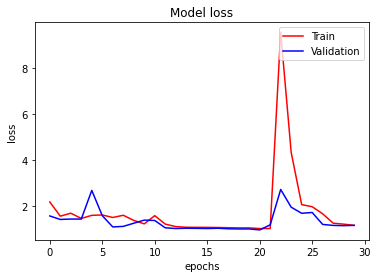

In [120]:
import matplotlib.pyplot as plt
  
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), loss_tr, color='red')
plt.plot(range(epochs), loss_val, color='blue')
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Sleep_1s_loss.png',bbox_inches = 'tight')
plt.show() 

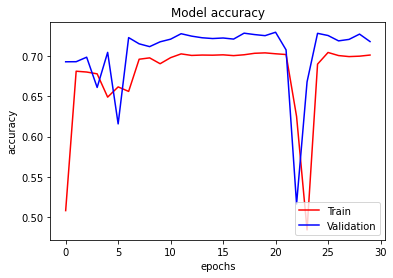

In [121]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), acc_tr, color='red')
plt.plot(range(epochs), acc_val, color='blue')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('Sleep_1s_accuracy.png',bbox_inches = 'tight')
plt.show()

In [122]:
for batch_idx, batch in enumerate(testLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        f_GAP, f_GVP =  FeatureEncoder(x1,x2).forward(b,c,f,t)

        pred  = model.forward(f_GAP, f_GVP)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
        loss = CrossEL(pred, label)
        
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0]

print(acc)
print(loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.6805555555555556
tensor(1.1550, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>)


In [123]:
label_list = []
predicted_list = []
for batch_idx, batch in enumerate(testLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        f_GAP, f_GVP =  FeatureEncoder(x1,x2).forward(b,c,f,t)

        pred  = model.forward(f_GAP, f_GVP)
        label = batch['y'].type(torch.float64).to(device)
        
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        label_list.extend(label.cpu().detach().numpy())
        predicted_list.extend(predicted.cpu().detach().numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [124]:
# confusion matrix 사용을 위한 라이브러리
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(label_list, predicted_list)
print(conf_matrix)

[[770   0   0   1   6   0]
 [ 25   0   0   0   0   0]
 [125   0   0   0   1   0]
 [ 40   0   2   0   0   0]
 [ 57   1   0   0   0   0]
 [ 68   0   0   0   0   0]]


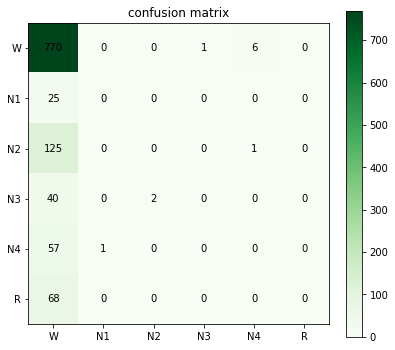

In [126]:
title = 'confusion matrix'
cmap=plt.cm.Greens
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)  # , cmap=plt.cm.Greens
plt.title(title, size=12)
plt.colorbar(fraction=0.05, pad=0.05)
tick_marks = np.arange(6, 6)
plt.yticks(np.arange(6), ('W','N1','N2','N3','N4','R'))
plt.xticks(np.arange(6), ('W','N1','N2','N3','N4','R'))


fmt = 'd' 
thresh = 1
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center", color="black" if conf_matrix[i, j] > thresh else "black")  #horizontalalignment
plt.savefig('SleepEDF_1s_confusion matrix.png',bbox_inches = 'tight')